In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import matplotlib.cm as cm
from scipy.integrate import simpson

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Parametersd
n_sub = 1.0 # Refractive index outside
n_core = 3.5  # Core refractive index
n_clad = 1.0 # Cladding refractive index
d = 8.0e-6  # Thickness in meters
wavelength = 1.55e-6  # Wavelength in meters

FWHM = 1e-6
L = 72.25806451612904 * 1e-6
L_pi = 192.68817204301078 * 1e-6

In [4]:
# Constants
k0 = 2 * np.pi / wavelength  # Free space wave number
V = k0 * d * np.sqrt(n_core ** 2 - n_clad ** 2)  # Normalized frequency for given parameters
sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))
print(f"V = {round(V, 3)}")

V = 108.771


In [5]:
x = np.linspace(-d / 2, d / 2, 1000000)  # Lateral positions
gaussian_profile = np.exp(-x**2 / (2 * sigma**2))

In [6]:
# Characteristic equations for TE modes
def characteristic_TE(b, V, n_core, n_clad, n_sub, N):
    a = (n_clad ** 2 - n_sub ** 2) / (n_core ** 2 - n_clad ** 2)
    lhs = np.arctan(np.sqrt(b / (1 - b))) + np.arctan(np.sqrt((b + a) / (1 - b)))
    rhs = V * np.sqrt(1 - b) - np.pi * N
    return lhs - rhs

In [7]:
max_modes = int(np.floor(V / np.pi)) + 1  # Number of modes (N=0, 1, 2)
print(f"Number of modes: {max_modes}")

b_te = []

Number of modes: 35


In [8]:
initial_b = [0.9999999 - N * 0.005 for N in range(max_modes)]

for N in range(max_modes):
    try:
        # Solve for TE modes
        b_te_solution = fsolve(characteristic_TE, initial_b[N], args=(V, n_core, n_clad, n_sub, N))[0]
        if 0 < b_te_solution < 1:
            b_te.append((N,b_te_solution))
        else:
            b_te.append((N, None))

    except:
        print(f"Error solving for mode N={N}: {e}")
        b_te.append((N, None))


In [9]:
# Compute effective indices (n_eff) for each b value
n_eff_te = [np.sqrt(b[1] * (n_core ** 2 - n_clad ** 2) + n_clad ** 2) if b[1] is not None else None for b in
            b_te]
betas = [n_eff * k0 for n_eff in n_eff_te]

In [10]:
# Print results for TE and TM modes
print("TE Modes:")
for N, b, neff in zip(range(max_modes), b_te, n_eff_te):
    print(f"Mode N={N},\t b={b[1]:.5},\tn_eff={neff:.5}")

TE Modes:
Mode N=0,	 b=0.9992,	n_eff=3.4987
Mode N=1,	 b=0.99678,	n_eff=3.4948
Mode N=2,	 b=0.99276,	n_eff=3.4883
Mode N=3,	 b=0.98713,	n_eff=3.4793
Mode N=4,	 b=0.97989,	n_eff=3.4675
Mode N=5,	 b=0.97105,	n_eff=3.4532
Mode N=6,	 b=0.9606,	n_eff=3.4361
Mode N=7,	 b=0.94854,	n_eff=3.4163
Mode N=8,	 b=0.93487,	n_eff=3.3937
Mode N=9,	 b=0.91961,	n_eff=3.3683
Mode N=10,	 b=0.90273,	n_eff=3.34
Mode N=11,	 b=0.88426,	n_eff=3.3088
Mode N=12,	 b=0.86418,	n_eff=3.2745
Mode N=13,	 b=0.84251,	n_eff=3.237
Mode N=14,	 b=0.81924,	n_eff=3.1963
Mode N=15,	 b=0.79437,	n_eff=3.1522
Mode N=16,	 b=0.76791,	n_eff=3.1047
Mode N=17,	 b=0.73985,	n_eff=3.0534
Mode N=18,	 b=0.71022,	n_eff=2.9983
Mode N=19,	 b=0.67899,	n_eff=2.9392
Mode N=20,	 b=0.64619,	n_eff=2.8757
Mode N=21,	 b=0.61181,	n_eff=2.8076
Mode N=22,	 b=0.57586,	n_eff=2.7347
Mode N=23,	 b=0.53835,	n_eff=2.6564
Mode N=24,	 b=0.49929,	n_eff=2.5724
Mode N=25,	 b=0.45868,	n_eff=2.482
Mode N=26,	 b=0.41654,	n_eff=2.3845
Mode N=27,	 b=0.37288,	n_eff=2.279

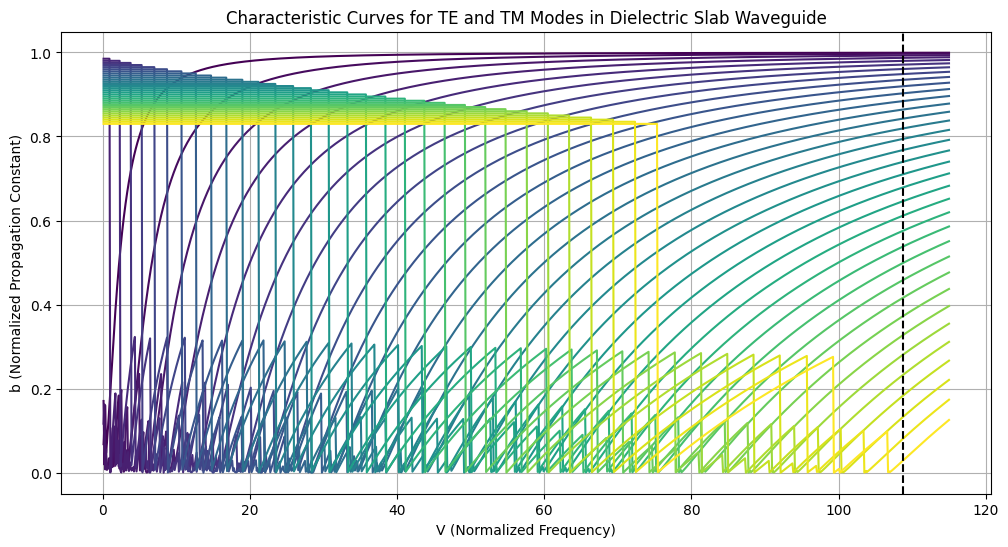

In [11]:
# Plot characteristic curves for TE and TM modes over a range of V
V_range = np.linspace(0.1, 115, 1000)  # Avoid V=0 for stability
b_values_te = {N: [fsolve(characteristic_TE, initial_b[N], args=(V, n_core, n_clad, n_sub, N))[0]
                   if 0 < fsolve(characteristic_TE, initial_b[N], args=(V, n_core, n_clad, n_sub, N))[0] < 1 else np.nan
                   for V in V_range] for N in range(max_modes)}


# Plot results
plt.figure(figsize=(12, 6))
colors = cm.viridis(np.linspace(0, 1, max_modes))  # Dynamically create unique colors

# TE Modes
for N in range(max_modes):
    plt.plot(V_range, b_values_te[N], label=f"TE Mode N={N}", linestyle='-', color=colors[N])


# Highlight V
plt.axvline(V, color='black', linestyle='--', label=f"V={V:.2f}")

plt.xlabel("V (Normalized Frequency)")
plt.ylabel("b (Normalized Propagation Constant)")
plt.title("Characteristic Curves for TE and TM Modes in Dielectric Slab Waveguide")
plt.grid()
plt.show()

In [12]:
calculate_p = lambda beta: np.sqrt(beta**2 - (n_clad * k0)**2)  # Decay constant in cladding
calculate_h = lambda beta: np.sqrt((n_core * k0)**2 - beta**2)  # Propagation constant in core

In [13]:
p_list = [calculate_p(beta) for beta in betas]
h_list = [calculate_h(beta) for beta in betas]

In [14]:
def calculate_E(h, p, x):
    field_profile = np.zeros_like(x)

    # Core region centered on 0: -d/2 <= x <= d/2
    core_region = (x >= -d/2) & (x <= d/2)
    field_profile[core_region] = np.cos(h * (x[core_region] +d/2)) + (p / h) * np.sin(h * (x[core_region] +d/2))

    # Left cladding: x < -d/2
    left_cladding = x < -d/2
    field_profile[left_cladding] = np.exp(p * (x[left_cladding] + d/2))

    # Right cladding: x > d/2
    right_cladding = x > d/2
    field_profile[right_cladding] = np.exp(-p * (x[right_cladding] - d/2))

    # Normalize the field profile to have its maximum value as 1
    field_profile /= max(field_profile)

    return field_profile


In [15]:
eigen_modes = [] 
for i in range(max_modes):
    eigen_mode = calculate_E(h_list[i], p_list[i], x)
    eigen_modes.append(eigen_mode)

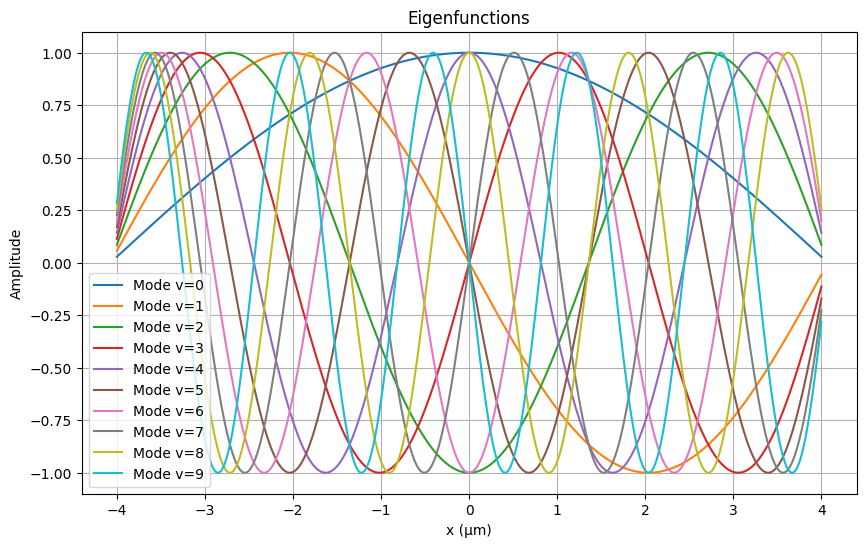

In [16]:
plt.figure(figsize=(10,6))
for v, psi in enumerate(eigen_modes[:10]):
    plt.plot(x * 1e6, psi, label= f"Mode v={v}")
plt.xlabel("x (µm)")
plt.ylabel("Amplitude")
plt.title("Eigenfunctions")
plt.grid()
plt.legend()
plt.show()

In [17]:
def calculate_coefficients(input_function, eigenfunctions, x):
    coefficients = []
    for eigenfunction in eigenfunctions:
        # Numerator: Integral of input_function * eigenfunction
        numerator = simpson(input_function * np.conj(eigenfunction))

        # Denominator: Integral of eigenfunction^2
        denominator = simpson(np.abs(eigenfunction)**2)

        # Coefficient for this mode
        coefficient = numerator / denominator
        coefficients.append(coefficient)

    return coefficients

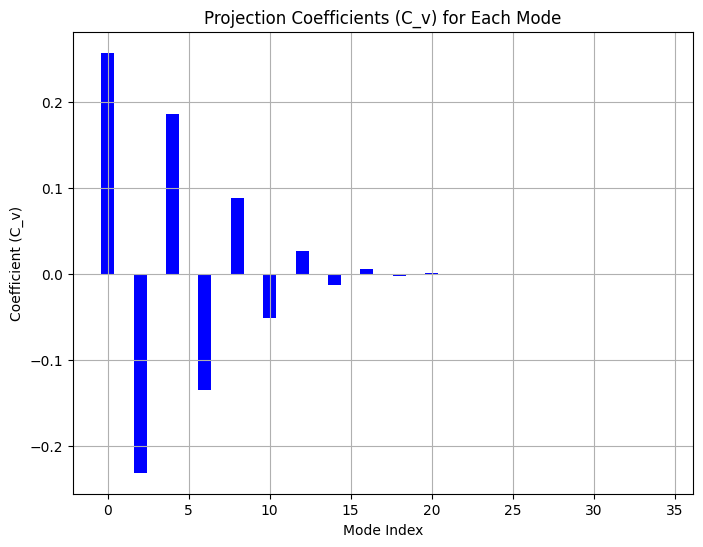

In [18]:
coefficients = calculate_coefficients(gaussian_profile, eigen_modes, x)

plt.figure(figsize=(8, 6))
plt.bar(range(max_modes), coefficients, color='blue')
plt.xlabel("Mode Index")
plt.ylabel("Coefficient (C_v)")
plt.title("Projection Coefficients (C_v) for Each Mode")
plt.grid()
plt.show()

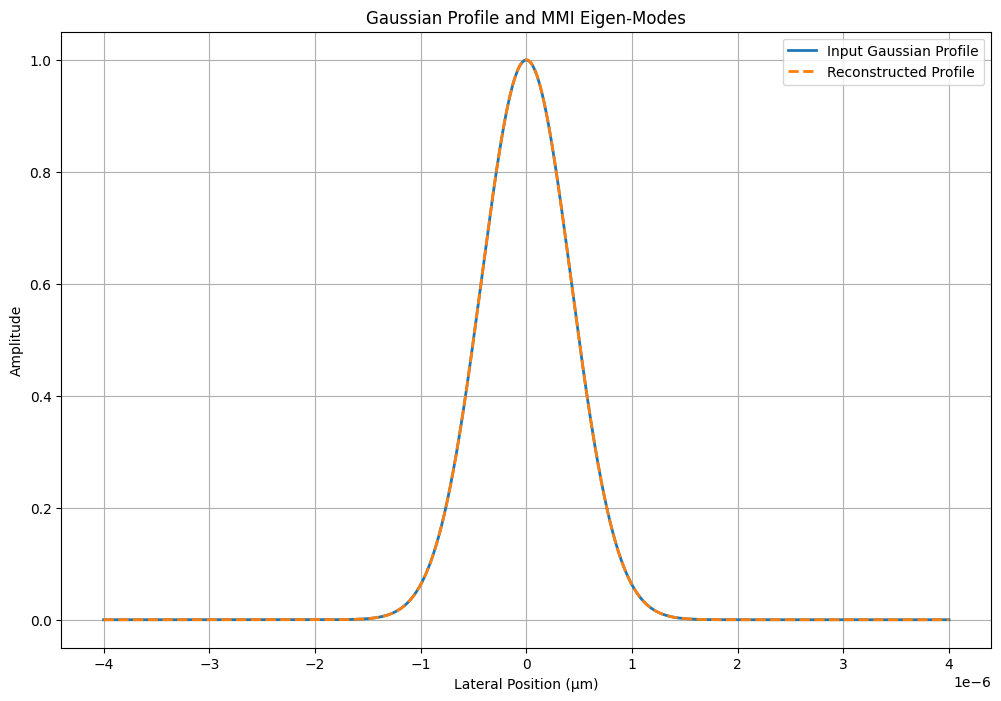

In [19]:
reconstructed_profile = sum(c * mode for c, mode in zip(coefficients, eigen_modes))

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(x, gaussian_profile, label="Input Gaussian Profile", linewidth=2)
plt.plot(x, reconstructed_profile, label="Reconstructed Profile", linestyle='--', linewidth=2)
plt.xlabel("Lateral Position (µm)")
plt.ylabel("Amplitude")
plt.title("Gaussian Profile and MMI Eigen-Modes")
plt.legend()
plt.grid()
plt.show()

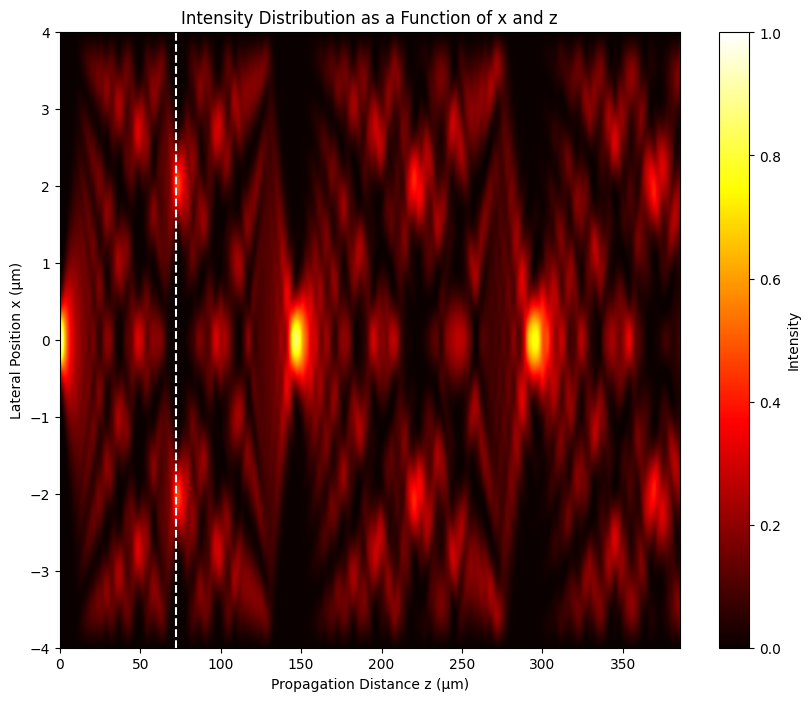

In [20]:
z = np.linspace(0, 2 * L_pi, 1000)  # Propagation distance
intensity = np.zeros((len(x), len(z)))

# Plot the intensity as a function of x and z
plt.figure(figsize=(10, 8))

plt.axvline(L * 1e6, color='white', linestyle='--')

# Calculate the intensity as a function of x and z
for zi, z_val in enumerate(z):
    field_at_z = np.zeros_like(x, dtype=complex)
    for v, mode in enumerate(eigen_modes):
        phase = np.exp(-1j * betas[v] * z_val)
        field_at_z += coefficients[v] * mode * phase
    intensity[:, zi] = np.abs(field_at_z)**2  # Intensity is the magnitude squared

plt.imshow(intensity, extent=[z[0] * 1e6, z[-1] * 1e6, x[0] * 1e6, x[-1] * 1e6],
           aspect='auto', origin='lower', cmap='hot')

plt.colorbar(label='Intensity')
plt.xlabel("Propagation Distance z (µm)")
plt.ylabel("Lateral Position x (µm)")
plt.title("Intensity Distribution as a Function of x and z")
plt.show()

In [21]:
field_at_L = np.zeros_like(x, dtype=complex)

for v, mode in enumerate(eigen_modes):
        phase = np.exp(-1j * betas[v] * L)
        field_at_L += coefficients[v] * mode * phase
    
field_at_L = np.abs(field_at_L)**2

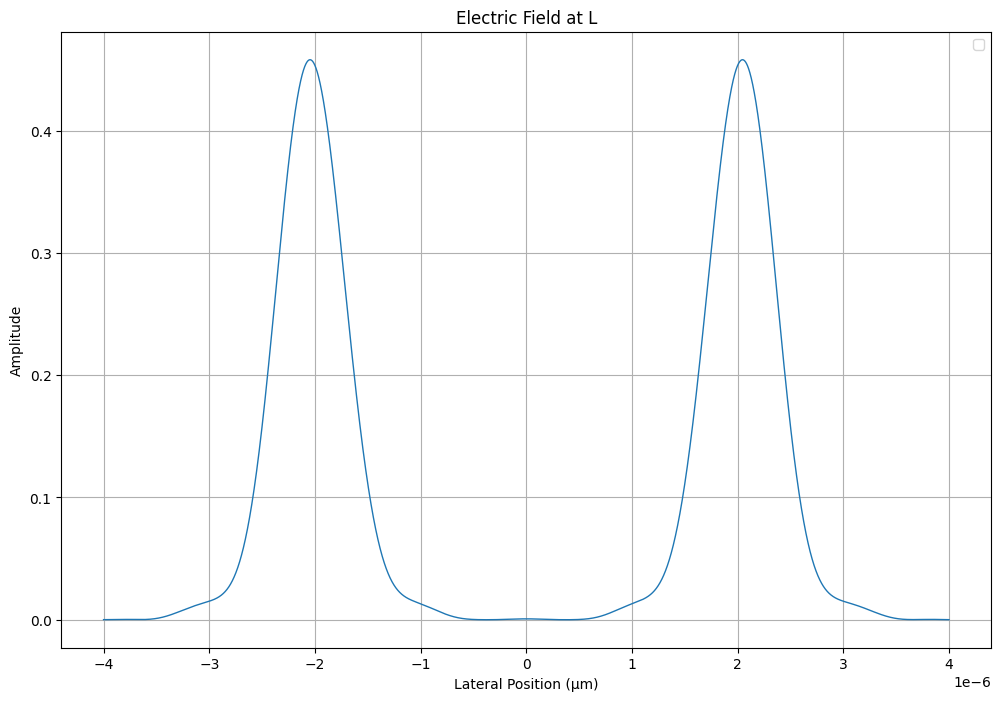

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(x,field_at_L , linewidth=1)
plt.xlabel("Lateral Position (µm)")
plt.ylabel("Amplitude")
plt.title("Electric Field at L")
plt.legend()
plt.grid()
plt.show()